# Covid19 Count Prediction

In this note book we will learn how to make predictions using time series data.

We are going to predict the number of covid cases for few days.

## Importing Libraries

In [1]:
"""
@author: Devavrat Singh Bisht
Data: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading Dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

## Data Preprocessing

### Extracting data for particular country

In [3]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,46116,46274,46516,46718,46837,46837,47072,47306,47516,47716,47851,48053,48116,48229,48527,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,37625,38182,39014,39719,40501,41302,42148,42988,43683,44436,45188,46061,46863,47742,48530,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,82221,83199,84152,85084,85927,86730,87502,88252,88825,89416,90014,90579,91121,91638,92102,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6712,6745,6790,6842,6904,6955,7005,7050,7084,7127,7162,7190,7236,7288,7338,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15103,15139,15251,15319,15361,15493,15536,15591,15648,15729,15804,15925,16061,16161,16188,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974


In [4]:
# The dataset contains data for a lot of countries
# for our purpose we are working on India's data
# you can use any other country if you want :)
country = 'India'

In [5]:
# Selecting the data only for the specified country
df_country = df[df["Country/Region"] == country]
# droping unwanted columns 
df_country = df_country.drop(columns=['Province/State',	'Country/Region',	'Lat',	'Long'])
# taking transpose of the dataframe
df_country = df_country.transpose()
# renaming the column
df_country.columns = ['confirmed']
# converting index into datetime format
df_country.index = pd.to_datetime(df_country.index,format='%m/%d/%y')

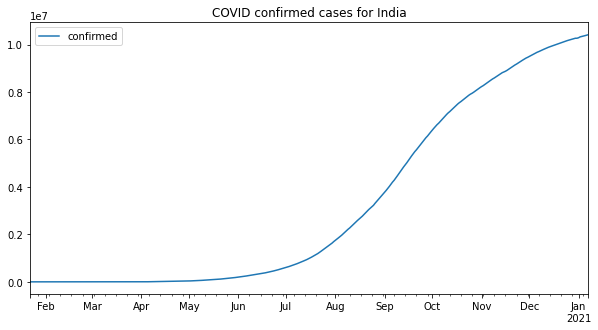

In [6]:
df_country.plot(figsize=(10,5),title="COVID confirmed cases for " + country)

In [7]:
print("Total days in the dataset", len(df_country))

Total days in the dataset 352


### Splitting data into Train and Test

In [8]:
# Using data of last 20% of days as testing
test_size = int(len(df_country)*0.2)

train=df_country.iloc[:-test_size]
test = df_country.iloc[-test_size:]

### Scaling the data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

### Generating Sequential Data

#### Train Data

In [10]:
# Use TimeSeriestrain_generator to generate data in sequences.
# Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

# Sequence size has an impact on prediction, especially since COVID is unpredictable!
# note that the sequence size should not be more than the test_size defined earliear
# a greater sequence size will cause problem for generating test data
seq_size = 14  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1

assert(seq_size<=test_size), "Sequence size more than Test size"

train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

# Check data shape from generator
x,y = train_generator[10]  # Check train_generator
# Takes 7 days as x and 8th day as y (for seq_size=7)

Total number of samples in the original training data =  282
Total number of samples in the generated data =  268


#### Test Data

In [11]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  70
Total number of samples in the generated data =  56


## Model Building

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 120,193
Trainable params: 120,193
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [13]:
history = model.fit(train_generator, validation_data=test_generator, epochs=50, steps_per_epoch=10)

Epoch 1/50
10/10 [==============================] - 3s 136ms/step - loss: 0.3174 - val_loss: 0.6312
Epoch 2/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0499 - val_loss: 0.0894
Epoch 3/50
10/10 [==============================] - 1s 74ms/step - loss: 0.0224 - val_loss: 0.0203
Epoch 4/50
10/10 [==============================] - 1s 73ms/step - loss: 0.0102 - val_loss: 9.5345e-04
Epoch 5/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 6/50
10/10 [==============================] - 1s 74ms/step - loss: 0.0039 - val_loss: 0.1220
Epoch 7/50
10/10 [==============================] - 1s 71ms/step - loss: 0.0098 - val_loss: 0.0249
Epoch 8/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0047 - val_loss: 0.1150
Epoch 9/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0066 - val_loss: 0.0534
Epoch 10/50
10/10 [==============================] - 1s 73ms/step - loss: 0.0177 - val_loss: 0.0067
Epoc

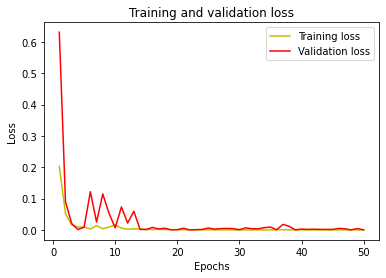

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Testing

In [15]:
# Empty list to store predictions
prediction = [] 

# Last data points in train to make the first test predictions.
current_batch = train_scaled[-seq_size:]
# Reshaping
current_batch = current_batch.reshape(1, seq_size, n_features)

In [16]:
# Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    
    # making predicitions  
    current_pred = model.predict(current_batch)[0]
    
    # appending the current prediction to our list
    prediction.append(current_pred)
    
    # updating the current batch by removing the first entry
    # and adding the current pred as the latest entry
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [17]:
# Inverse transform to get the orignial data
rescaled_prediction = scaler.inverse_transform(prediction)

# Getting dates from test data
days_array = test.index

In [18]:
# Add new dates for the forecast period
for k in range(0, future):
    days_array = days_array.append(days_array[-1:] + pd.DateOffset(1))

In [19]:
# Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual","predicted"], index=days_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual"] = test["confirmed"]

In [20]:
df_forecast

,actual,predicted
2020-10-30,8137119.0,8.122371e+06
2020-10-31,8184082.0,8.169743e+06
2020-11-01,8229313.0,8.216119e+06
2020-11-02,8267623.0,8.261890e+06
2020-11-03,8313876.0,8.307362e+06
...,...,...
2021-01-10,NaN,1.145799e+07
2021-01-11,NaN,1.151283e+07
2021-01-12,NaN,1.156818e+07
2021-01-13,NaN,1.162404e+07


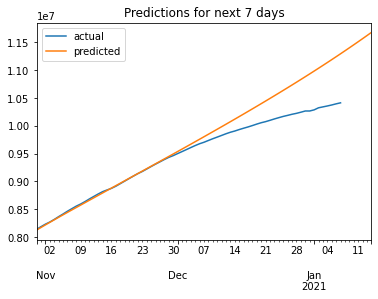

In [21]:
# Plot
df_forecast.plot(title="Predictions for next {} days".format(future))